## Visualizing context extraction

In [1]:
# Define embeddings - remember to change the embeddings file to 1000, 2000 or 4000
# Select context, context_medium or context_long depending on 1000, 2000 or 4000
book = [2450, 'ww2'][1]
embedding_length = [1000, 2000, 4000][2]
print(f"book: {book}, Embedding length: {embedding_length}")
ctx_length_to_name = {1000: 'context', 2000: 'context_medium', 4000: 'context_long'}

# use cuda
import torch
import tensorflow as tf
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

book: ww2, Embedding length: 4000


device(type='cuda')

In [9]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
import matplotlib as mpl
import matplotlib.pyplot as plt

# Get data
with open(f'Neural Search/data/{book}.pkl', 'rb') as f:
    df_data = pickle.load(f)
df_data.reset_index(inplace=True)
with open(f'Neural Search/Embeddings/{book}_context_embeddings_{embedding_length}.pkl', 'rb') as f:
    context_embeddings = pickle.loads(f.read())
with open(f'Neural Search/Embeddings/{book}_question_embeddings.pkl', 'rb') as f:
    question_embeddings = pickle.loads(f.read())

In [5]:
u_ctx_short = df_data['context'].unique()

ctx_mapping_short_to_medium = {}

for i in range(len(u_ctx_short)-1):
    if i % 2 == 0:
        ctx_mapping_short_to_medium[u_ctx_short[i]] = u_ctx_short[i]+u_ctx_short[i+1]
    else:
        ctx_mapping_short_to_medium[u_ctx_short[i]] = u_ctx_short[i-1]+u_ctx_short[i]

data = []
for ctx in df_data['context']:
    val = ctx_mapping_short_to_medium.get(ctx)
    if val:
        data.append(val)
    else:
        data.append(ctx)

df_data['context_medium'] = data

u_ctx_medium = df_data['context_medium'].unique()

ctx_mapping_medium_to_long = {}

n = len(u_ctx_medium)
for i in range(n-1,0,-1):
    if i % 2 == n % 2:
        ctx_mapping_medium_to_long[u_ctx_medium[i]] = u_ctx_medium[i]+u_ctx_medium[i+1]
    else:
        ctx_mapping_medium_to_long[u_ctx_medium[i]] = u_ctx_medium[i-1]+u_ctx_medium[i]

data = []
for ctx in df_data['context_medium']:
    val = ctx_mapping_medium_to_long.get(ctx)
    if val:
        data.append(val)
    else:
        data.append(ctx)

df_data['context_long'] = data

In [6]:
# Make combinations
from collections import defaultdict

is_added = defaultdict(lambda: 0)

contexts = df_data[ctx_length_to_name[embedding_length]].unique()
data = []

for i,row in df_data.iterrows():
    if is_added[row['question']]:
        continue

    dft = pd.DataFrame(columns=['context', 'question', 'label'])
    dft['context'] = contexts
    dft['question'] = row['question']
    dft['label'] = 0

    for ctx in df_data.loc[df_data['question'] == row['question'], ctx_length_to_name[embedding_length]]:
        dft.loc[dft['context']==ctx,'label'] = 1

    data.append(dft)

    is_added[row['question']] = 1
df = pd.concat(data, ignore_index=True)
sum(df['label'])

1255

In [18]:
# Select for train and test
n_test_q = int(0.2*len(df['question'].unique()))
test_q = np.random.choice(df['question'].unique(), n_test_q, replace=False)

# # Make dataframes for repeated contexts
# df_test_all_ctx = df.loc[df['question'].isin(test_q)]
# df_test_all_ctx.reset_index(inplace=True, drop=True)
df_par_all_ctx =  df.loc[~df['question'].isin(test_q)]
df_par_all_ctx.reset_index(inplace=True, drop=True)

# # Select validation questions
n_val_q = int(0.1*len(df_par_all_ctx['question'].unique()))
val_q = np.random.choice(df_par_all_ctx['question'].unique(), n_val_q, replace=False)

# # Make dataframes for train and validation
# df_val_all_ctx =  df_par_all_ctx.loc[df_par_all_ctx['question'].isin(val_q)]
# df_val_all_ctx.reset_index(inplace=True, drop=True)
df_train_all_ctx =  df_par_all_ctx.loc[~df_par_all_ctx['question'].isin(val_q)]
df_train_all_ctx.reset_index(inplace=True, drop=True)

# Make train and test data - Context and question are concatenated together
X_train_all_ctx = np.array([np.concatenate((context_embeddings[ctx],question_embeddings[q])) for ctx,q in zip(df_train_all_ctx['context'].values, df_train_all_ctx['question'].values)])
y_train_all_ctx = np.array([i for i in df_train_all_ctx['label'].values])

# X_val_all_ctx = np.array([np.concatenate((context_embeddings[ctx],question_embeddings[q])) for ctx,q in zip(df_val_all_ctx['context'].values, df_val_all_ctx['question'].values)])
# y_val_all_ctx = np.array([i for i in df_val_all_ctx['label'].values])

# X_test_all_ctx = np.array([np.concatenate((context_embeddings[ctx],question_embeddings[q])) for ctx,q in zip(df_test_all_ctx['context'].values, df_test_all_ctx['question'].values)])
# y_test_all_ctx = np.array([i for i in df_test_all_ctx['label'].values])

# # Shuffle
# idx_train_all_ctx = np.random.permutation(len(X_train_all_ctx))
# X_train_all_ctx = X_train_all_ctx[idx_train_all_ctx]
# y_train_all_ctx = y_train_all_ctx[idx_train_all_ctx]

# idx_val_all_ctx = np.random.permutation(len(X_val_all_ctx))
# X_val_all_ctx = X_val_all_ctx[idx_val_all_ctx]
# y_val_all_ctx = y_val_all_ctx[idx_val_all_ctx]

# idx_test_all_ctx = np.random.permutation(len(X_test_all_ctx))
# X_test_all_ctx = X_test_all_ctx[idx_test_all_ctx]
# y_test_all_ctx = y_test_all_ctx[idx_test_all_ctx]

In [94]:


def show_book_contexts(values, title="", size=(14, 1), linewidth=1):
    length = len(values)
    values = (values - values.min())/(values.max() - values.min())

    # fig, ax = plt.subplots()
    fig, ax = plt.subplots(figsize=size)
    _, _, patches = ax.hist(range(length), length, edgecolor='black', linewidth=linewidth)
    for i, v in enumerate(values):
        patches[i].set_facecolor(color=colorFader('#1f77b4', 'red', v))
    # for i, v in enumerate(values):
    #     ax.axvline(i, color=colorFader('#1f77b4', 'red', v), linewidth=1) 
    # plt.plot(values)
    # values = np.array(values).flatten()
    # plt.bar(range(len(values)), values)
    if title:
        plt.title(title, fontsize=15)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.axis('off')
    plt.show()

def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

# show_book_contexts(output, "", (6,0.7), 2)


len(query) = 768
contexts.shape = (64, 768)
query_book.shape = (64, 1536)
2/2 [==============================] - 0s 2ms/step


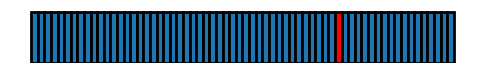

In [103]:
# Sample a random question from the training data
random_idx = np.random.randint(0, len(X_train_all_ctx))
random_question = X_train_all_ctx[random_idx]

query = random_question[:len(random_question)//2]
contexts = np.array(list(context_embeddings.values()))
print(f'{len(query) = }\n{contexts.shape = }')

query_book = np.array([np.concatenate((ctx, query)) for ctx in contexts])
print(f'{query_book.shape = }')

# Load model

neural_net_b = load_model(f'Neural Search/Results/{embedding_length}/hist_nn_{book}')
output = neural_net_b.predict(query_book)

show_book_contexts(output, "", (6,0.7), 2)